In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (5, 5)})

In [7]:
test_i = 0
with open(f"../tests/{test_i}.test") as file:
    ue_num = int(file.readline())
    print(ue_num)

    toa_all = np.zeros([ue_num, 4])
    bs_pos = np.zeros((4, 2))
    ue_pos = np.zeros([ue_num, 2], float)

    file.readline()
    file.readline()

    for i in range(ue_num):
        line = file.readline()
        toa_all[i] = np.asarray(line.strip().split(" "), dtype=float)

    for i in range(4):
        bs_pos[i] = np.asarray(file.readline().split(" "), dtype=float)

    for i in range(ue_num):
        ue_pos[i] = np.asarray(file.readline().split(" "), dtype=float)


7


In [8]:
max_iter_num = 100
max_iter_ue = 50
room_size = 20
c_ns = 0.299792458

np.random.seed(47)


In [9]:
Q = np.zeros((2, 2))
M = (bs_pos[0] + bs_pos[1]) / 2
R = bs_pos[0] - M
Q = np.array([
    [R[0], -R[1]],
    [R[1], R[0]]
]) / np.linalg.norm(R)

In [10]:
h = []
m = max_iter_ue * 2

dd = []
ddt = []
for i in range(ue_num):
    ue_pos_i = ue_pos[i]
    c = np.linalg.norm(bs_pos[0] - bs_pos[1]) / 2
    dt = np.linalg.norm(ue_pos_i - bs_pos[0]) - np.linalg.norm(ue_pos_i - bs_pos[1])
    d = (toa_all[i, 0] - toa_all[i, 1]) * c_ns
    dd.append(d)
    ddt.append(dt)
    # print(f"d: {d}, true d: {d1}")
    a = np.abs(d) / 2
    if a > c:
        h.append([])
    else:
        # print(f"c: {c}, a: {a}", file=sys.stderr)
        b = np.sqrt(c ** 2 - a ** 2)
        tmax = max(np.arccosh(room_size / a), np.arcsinh(room_size / b))
        ts = np.log(1 + (np.linspace(0, 1, m // 2))) / np.log(2) * tmax
        # ts = (np.linspace(0, 1, m // 2)) ** 0.5  * tmax
        t = np.concatenate([-ts[::-1], ts])
        x = np.zeros((2, m))
        x[0] = np.sign(-d) * a * np.cosh(t)
        x[1] = b * np.sinh(t)
        y = Q @ x + M[:, None]
        y = y[:, (np.abs(y) > room_size / 2).sum(axis=0) == 0]
        h.append(y)

dd = np.array(dd)
ddt = np.array(ddt)
np.sqrt(np.mean((dd - ddt) ** 2))


3.2572109657830186

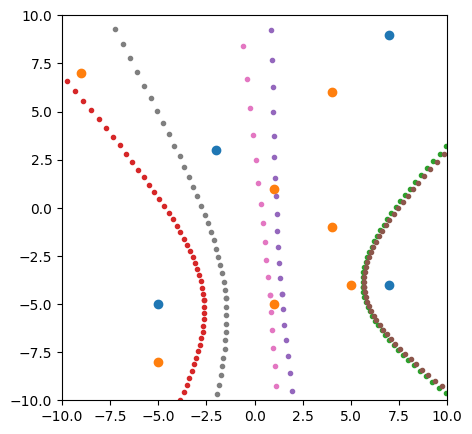

In [12]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_box_aspect(1)
ax.scatter(*bs_pos.T)
ax.scatter(*ue_pos.T)
# for y in h[:10]:
for y in h:
    if len(y) > 0:
        # plt.plot(*y)
        plt.scatter(*y, linewidths=1, marker='.')
# ax.plot(*y)
plt.show()

In [13]:
%%time
ue_pos_est = np.zeros((ue_num, 2), dtype=float)
bs_pos_est = bs_pos.copy()

min_loss = np.inf
tdoa_measured = toa_all[:, 1:] - toa_all[:, 0:1]
ue_pos_best = ue_pos_est.copy()
bs_pos_best = bs_pos_est.copy()
for iter in range(max_iter_num):
    bs_pos_est[2, 0] = (np.random.rand() - 1) * room_size / 2
    bs_pos_est[3, 0] = (np.random.rand()) * room_size / 2
    bs_pos_est[2, 1] = (np.random.rand()) * room_size / 2
    bs_pos_est[3, 1] = (np.random.rand()) * room_size / 2

    loss_tdoa = 0
    for ue_i in range(ue_num):
        min_loss_ue = np.inf
        for iter_ue in range(max_iter_ue):
            if len(h[ue_i]) > 0:
            # if False:
                # ue_pos_est_i = (np.random.rand(2) - 0.5) * room_size
                ch = np.random.randint(0, len(h[ue_i].T))
                ue_pos_est_i = h[ue_i].T[ch]
            else:
                ue_pos_est_i = (np.random.rand(2) - 0.5) * room_size

            toa_est_i = (
                    np.sqrt(
                        (bs_pos_est[:, 0] - ue_pos_est_i[0]) ** 2
                        + (bs_pos_est[:, 1] - ue_pos_est_i[1]) ** 2
                    )
                    / c_ns
            )
            tdoa_est_i = toa_est_i[1:] - toa_est_i[0:1]
            loss_tdoa_i = np.sum((tdoa_est_i - tdoa_measured[ue_i, :]) ** 2)

            if loss_tdoa_i < min_loss_ue:
                ue_pos_est[ue_i, :] = ue_pos_est_i.copy()
                min_loss_ue = loss_tdoa_i

        loss_tdoa += min_loss_ue

    if loss_tdoa < min_loss:
        ue_pos_best = ue_pos_est.copy()
        bs_pos_best = bs_pos_est.copy()
        min_loss = loss_tdoa

ue_pos_est = ue_pos_best
bs_pos_est = bs_pos_best


CPU times: user 1.4 s, sys: 3.96 ms, total: 1.41 s
Wall time: 1.41 s


In [14]:
print(bs_pos_est)

[[-5.00000000e+00 -5.00000000e+00]
 [ 7.00000000e+00 -4.00000000e+00]
 [-9.11810425e-01  2.07329542e+00]
 [ 2.84704202e-04  9.06658118e+00]]


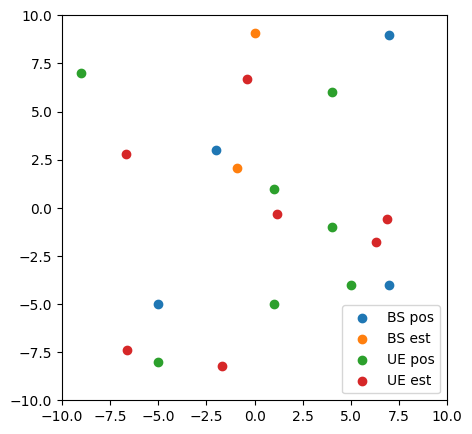

In [15]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_box_aspect(1)
ax.scatter(*bs_pos.T, label="BS pos")
ax.scatter(*bs_pos_est[2:].T, label="BS est")
ax.scatter(*ue_pos.T, label="UE pos")
ax.scatter(*ue_pos_est.T, label="UE est")


plt.legend()
plt.show()

In [16]:
# Loss explicitly
Dbs = np.sqrt(np.mean(np.sum((bs_pos_est - bs_pos) ** 2, axis=1), axis=0))
Due = np.sqrt(np.mean(np.sum((ue_pos_est - ue_pos) ** 2, axis=1), axis=0))

res = round((1 / (1 + Dbs) + 1 / (1 + Due)) * 5 * 10 ** 6)
print(res)

2201328


In [17]:
print(bs_pos_est[2:])

[[-9.11810425e-01  2.07329542e+00]
 [ 2.84704202e-04  9.06658118e+00]]


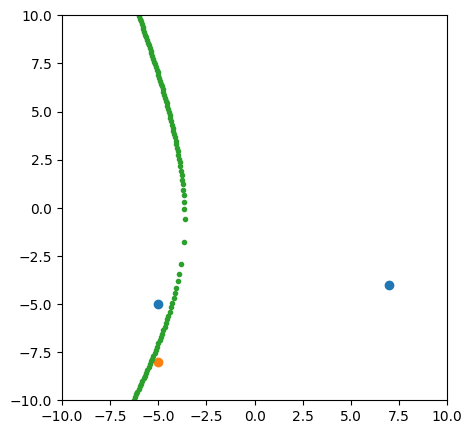

In [18]:
# external hyperbolas check
hx = [-6.01577, -5.9673, -5.91904, -5.87099, -5.82315, -5.77551, -5.72809, -5.68087, -5.63387, -5.58709, -5.54051, -5.49415, -5.44801, -5.40209, -5.35639, -5.31091, -5.26565, -5.22061, -5.1758, -5.13122, -5.08688, -5.04276, -4.99888, -4.95524, -4.91184, -4.86869, -4.82578, -4.78313, -4.74073, -4.6986, -4.65673, -4.61513, -4.57381, -4.53277, -4.49202, -4.45157, -4.41143, -4.3716, -4.3321, -4.29294, -4.25413, -4.21568, -4.17762, -4.13997, -4.10274, -4.06596, -4.02966, -3.99388, -3.95865, -3.92404, -3.89009, -3.85689, -3.82453, -3.79314, -3.76287, -3.73396, -3.70674, -3.68172, -3.65974, -3.64249, -3.63432, -3.68126, -3.82361, -3.91119, -3.99005, -4.06455, -4.13635, -4.20632, -4.27497, -4.34261, -4.40949, -4.47577, -4.54157, -4.60699, -4.67211, -4.73698, -4.80166, -4.86619, -4.93061, -4.99495, -5.05924, -5.12349, -5.18773, -5.25198, -5.31624, -5.38055, -5.4449, -5.50931, -5.57379, -5.63835, -5.703, -5.76775, -5.8326, -5.89755, -5.96263, -6.02783, -6.09315, -6.1586, -6.2242, -6.28993,]
hy=[9.96191, 9.8238, 9.68566, 9.54747, 9.40921, 9.27087, 9.13243, 8.99387, 8.85519, 8.71635, 8.57735, 8.43815, 8.29874, 8.1591, 8.0192, 7.87901, 7.73852, 7.59769, 7.45649, 7.31489, 7.17287, 7.03037, 6.88737, 6.74382, 6.59969, 6.45492, 6.30947, 6.16328, 6.01629, 5.86846, 5.7197, 5.56994, 5.41912, 5.26714, 5.1139, 4.95932, 4.80326, 4.64562, 4.48625, 4.325, 4.1617, 3.99616, 3.82815, 3.65743, 3.48372, 3.30669, 3.12596, 2.94109, 2.75155, 2.5567, 2.35577, 2.1478, 1.9316, 1.7056, 1.46773, 1.21515, 0.943722, 0.647108, 0.314579, -0.0748588, -0.575622, -1.76405, -2.94485, -3.43796, -3.81972, -4.14454, -4.43342, -4.69708, -4.94187, -5.17191, -5.39006, -5.59838, -5.79844, -5.99143, -6.17831, -6.35986, -6.5367, -6.70938, -6.87832, -7.04392, -7.20649, -7.36632, -7.52367, -7.67873, -7.83172, -7.98279, -8.13211, -8.27981, -8.42601, -8.57083, -8.71437, -8.85672, -8.99797, -9.1382, -9.27747, -9.41585, -9.55342, -9.69021, -9.82629, -9.96171, ]

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_box_aspect(1)
ax.scatter(*bs_pos[:2].T)
ax.scatter(*ue_pos[1].T)
ax.scatter(hx, hy, marker='.')
# ax.scatter(h[1][0], h[1][1], marker='.')
plt.show()

## Hyperbolas intersection method

In [27]:
ue_pos_est = np.zeros((ue_num, 2), dtype=float)
bs_pos_est = bs_pos.copy()

min_loss = np.inf
tdoa_measured = toa_all[:, 1:] - toa_all[:, 0:1]
ue_pos_best = ue_pos_est.copy()
bs_pos_best = bs_pos_est.copy()


xy_i1 = bs_pos[1:] - bs_pos[0]
cd = toa_all * c_ns
cd_i = cd[:, 1:] - cd[:, 0, None]
k = (bs_pos ** 2).sum(axis=1)

for iter in range(max_iter_num):
    bs_pos_est[2, 0] = (np.random.rand() - 1) * room_size / 2
    bs_pos_est[3, 0] = (np.random.rand()) * room_size / 2
    bs_pos_est[2, 1] = (np.random.rand()) * room_size / 2
    bs_pos_est[3, 1] = (np.random.rand()) * room_size / 2

    loss_tdoa = 0
    for ue_i in range(ue_num):
        min_loss_ue = np.inf
        for iter_ue in range(max_iter_ue):
            #if len(h[ue_i]) > 0:
            #    # ue_pos_est_i = (np.random.rand(2) - 0.5) * room_size
            #    ch = np.random.randint(0, len(h[ue_i].T))
            #    # ue_pos_est_i = h[ue_i].T[ch] + np.random.normal(0, 1, 2)
            #    ue_pos_est_i = h[ue_i].T[ch]
            #else:
            #    ue_pos_est_i = (np.random.rand(2) - 0.5) * room_size
            A = np.hstack((xy_i1, cd_i[ue_i, :, None]))
            b = (k[1:] - k[0] - cd_i[ue_i] ** 2) / 2
            pos, res, rank, s = np.linalg.lstsq(A, b, rcond=None)
            ue_pos_est_i = pos[:-1]

            toa_est_i = (
                np.sqrt(
                    (bs_pos_est[:, 0] - ue_pos_est_i[0]) ** 2
                    + (bs_pos_est[:, 1] - ue_pos_est_i[1]) ** 2
                )
                / c_ns
            )
            tdoa_est_i = toa_est_i[1:] - toa_est_i[0:1]
            #  loss_tdoa_i = np.sum((tdoa_est_i - tdoa_measured[ue_i, :]) ** 2)
            loss_tdoa_i = np.sum(np.abs(tdoa_est_i - tdoa_measured[ue_i, :]))

            if loss_tdoa_i < min_loss_ue:
                ue_pos_est[ue_i, :] = ue_pos_est_i.copy()
                min_loss_ue = loss_tdoa_i

            ue_pos_est_i = (np.random.rand(2) - 0.5) * room_size
            toa_est_i = (
                np.sqrt(
                    (bs_pos_est[:, 0] - ue_pos_est_i[0]) ** 2
                    + (bs_pos_est[:, 1] - ue_pos_est_i[1]) ** 2
                )
                / c_ns
            )
            tdoa_est_i = toa_est_i[1:] - toa_est_i[0:1]
            #  loss_tdoa_i = np.sum((tdoa_est_i - tdoa_measured[ue_i, :]) ** 2)
            loss_tdoa_i = np.sum(np.abs(tdoa_est_i - tdoa_measured[ue_i, :]))

            if loss_tdoa_i < min_loss_ue:
                ue_pos_est[ue_i, :] = ue_pos_est_i.copy()
                min_loss_ue = loss_tdoa_i

        loss_tdoa += min_loss_ue

    if loss_tdoa < min_loss:
        ue_pos_best = ue_pos_est.copy()
        bs_pos_best = bs_pos_est.copy()
        min_loss = loss_tdoa

ue_pos_est = ue_pos_best
bs_pos_est = bs_pos_best

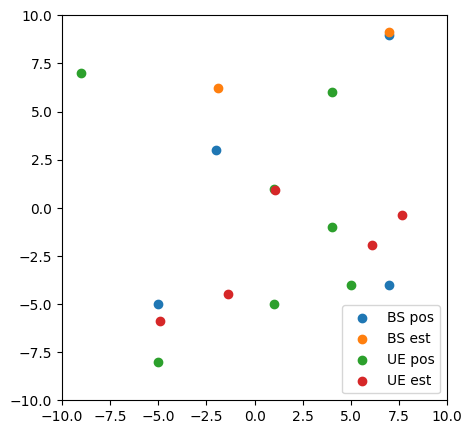

In [30]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_box_aspect(1)
ax.scatter(*bs_pos.T, label="BS pos")
ax.scatter(*bs_pos_est[2:].T, label="BS est")
ax.scatter(*ue_pos.T, label="UE pos")
ax.scatter(*ue_pos_est.T, label="UE est")
# k = 1
# ax.scatter(*ue_pos[k].T, label="UE pos")
# ax.scatter(*ue_pos_est[k].T, label="UE est")


plt.legend()
plt.show()